In [1]:
import numpy as np
import pandas as pd
import random
from datetime import datetime
import holidays
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import time
import mplleaflet
pd.set_option('display.max_columns',60)
import warnings
warnings.filterwarnings('ignore')

# Step 1: Define Helper Functions

In [2]:
def plot_inertia(km, X, n_cluster_range):
    inertias = []
    for i in n_cluster_range:
        km.set_params(n_clusters=i)
        km.fit(X)
        inertias.append(km.inertia_)
    plt.plot(n_cluster_range, inertias, marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

# Step 2: Load Dataset

In [3]:
train_df = pd.read_csv('train.csv',index_col = 0)
test_df = pd.read_csv('test.csv',index_col = 0)

# Step 3: EDA

## Distribution of Target Variable (Hourly Checkout Counts for Start Stations)

In [4]:
train_df.start_station_checkout_counts.describe()

count    2.625074e+06
mean     1.362840e+01
std      1.514532e+01
min      1.000000e+00
25%      5.000000e+00
50%      9.000000e+00
75%      1.700000e+01
max      3.070000e+02
Name: start_station_checkout_counts, dtype: float64

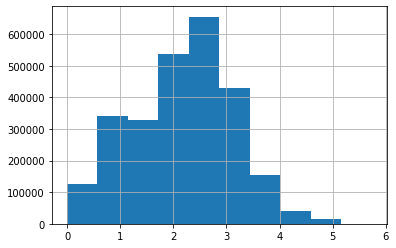

In [5]:
np.log(train_df.start_station_checkout_counts).hist()

- After a log transformation, the distribution of target varaible (hourly checkout counts for all start stations) follows a normal distribution 

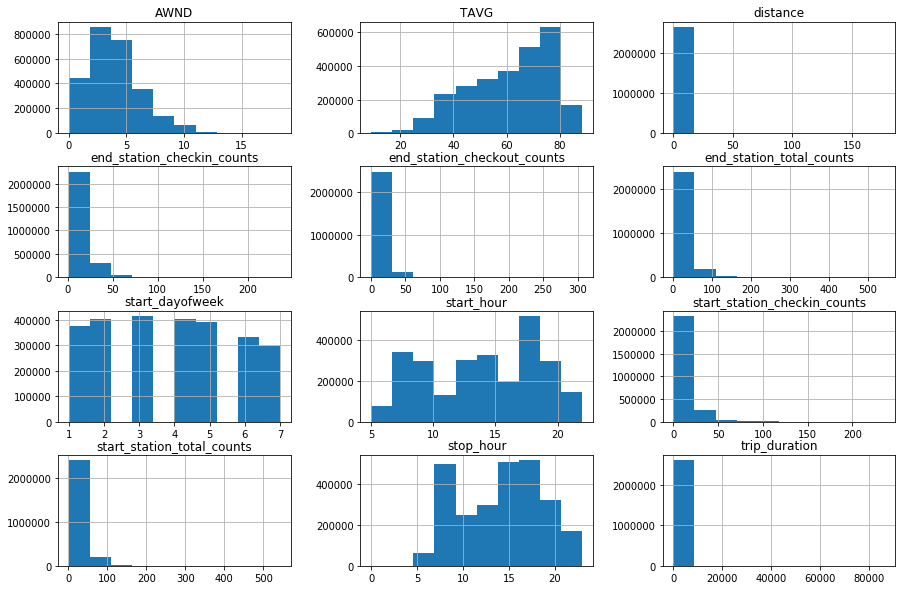

In [6]:
train_df[['trip_duration','start_dayofweek','start_hour','stop_hour','start_station_checkin_counts',\
          'start_station_total_counts','distance','end_station_checkin_counts','end_station_checkout_counts',\
         'end_station_total_counts','AWND','TAVG']].hist(figsize=(15,10));

- At a glance, a lot of features are highly right skewed.

## Seasonal Trend 

- Train Dataset

In [7]:
# Time Series of Trip Count
daily_trip = train_df[['start_date','trip_per_day','daily_avg_trip_duration','daily_avg_distance']].sort_values(by='start_date')
daily_trip.columns = ['Date','Daily Trip Count','Avg Trip Duration','Avg Distance']
daily_trip = daily_trip.groupby('Date').agg('mean').reset_index().set_index('Date')

- Test Dataset

In [8]:
daily_trip_test = test_df[['start_date','trip_per_day','daily_avg_trip_duration','daily_avg_distance']].sort_values(by='start_date')
daily_trip_test.columns = ['Date','Daily Trip Count','Avg Trip Duration','Avg Distance']
daily_trip_test = daily_trip_test.groupby('Date').agg('mean').reset_index().set_index('Date')

### Time Series Plot of Daily Trip Counts, Average Trip Duration(s) and Average Distance (mile)

Text(0, 0.5, 'Avg Distance(mile)')

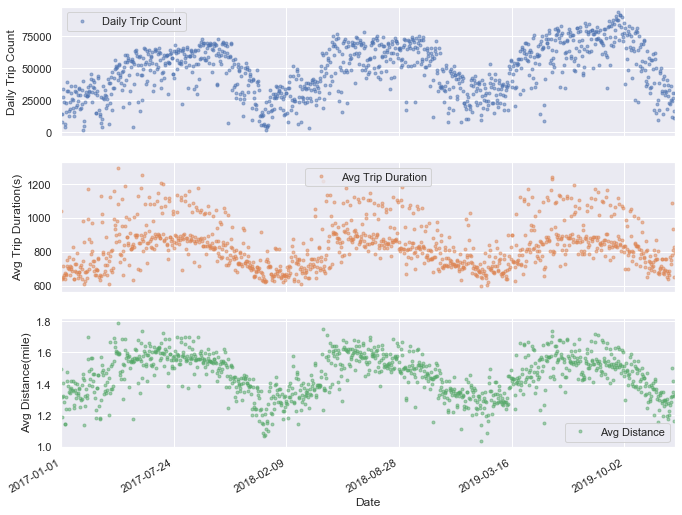

In [9]:
sns.set(rc={'figure.figsize':(11, 4)})
cols_plot = ['Daily Trip Count','Avg Trip Duration','Avg Distance']
axes = daily_trip[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', figsize=(11, 9), subplots=True)
axes[0].set_ylabel('Daily Trip Count')
axes[1].set_ylabel('Avg Trip Duration(s)')
axes[2].set_ylabel('Avg Distance(mile)')

### Monthly Aaverage Trip Counts

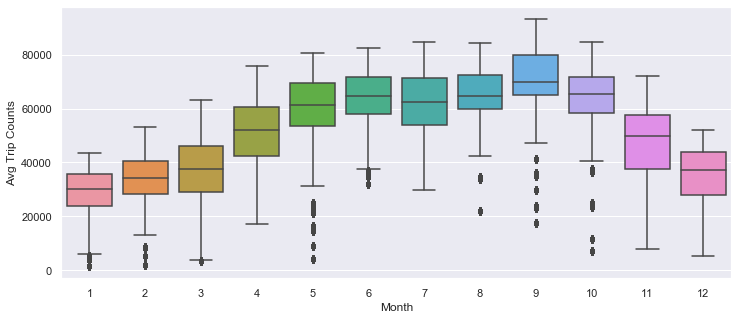

In [10]:
month_trip = train_df[['start_month','trip_per_day','daily_avg_trip_duration','daily_avg_distance']].sort_values(by='start_month')
month_trip.columns=['Month','Avg Trip Counts','Avg Trip Duration','Avg Distance'] 
plt.figure(figsize=(12,5))
sns.set_style('darkgrid')
sns.boxplot(x="Month", y="Avg Trip Counts", data=month_trip);

### Monthly Average Trip Duration(s)

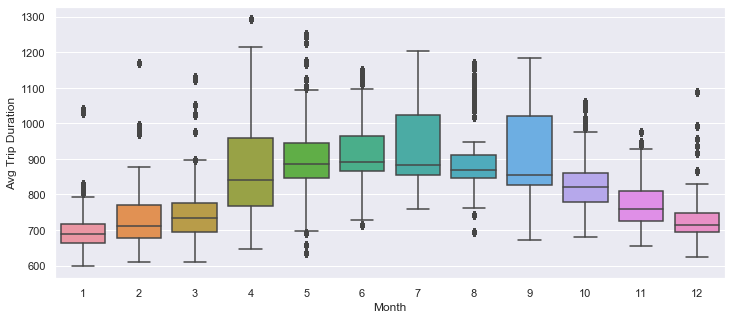

In [11]:
plt.figure(figsize=(12,5))
sns.set_style('darkgrid')
sns.boxplot(x="Month", y="Avg Trip Duration",  data=month_trip);

### Monthly Average Bike Distance(mile)

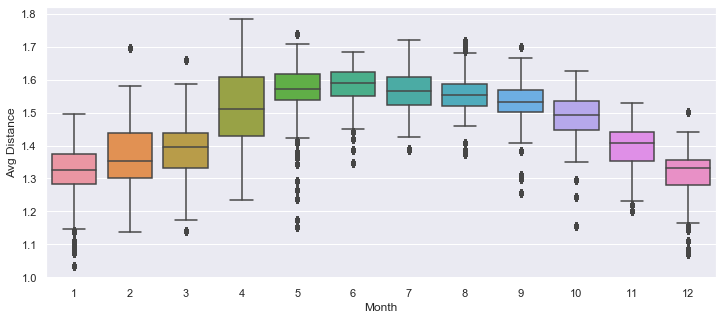

In [12]:
plt.figure(figsize=(12,5))
sns.set_style('darkgrid')
sns.boxplot(x="Month", y="Avg Distance", data=month_trip);

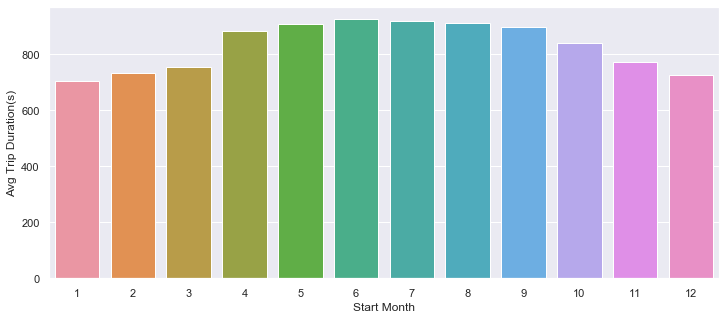

In [13]:
monthly_tripduration = train_df.groupby('start_month').mean()[['trip_duration']].reset_index()
monthly_tripduration.columns=['Start Month','Avg Trip Duration(s)']
plt.figure(figsize=(12,5))
sns.set_style('darkgrid')
sns.barplot('Start Month','Avg Trip Duration(s)', data = monthly_tripduration);

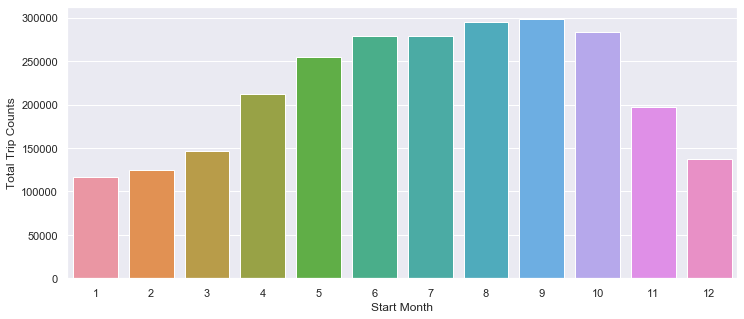

In [14]:
monthly_trip = train_df.groupby('start_month').count()[['trip_duration']].reset_index()
monthly_trip.columns=['Start Month','Total Trip Counts']
plt.figure(figsize=(12,5))
sns.set_style('darkgrid')
sns.barplot('Start Month', 'Total Trip Counts',data = monthly_trip);

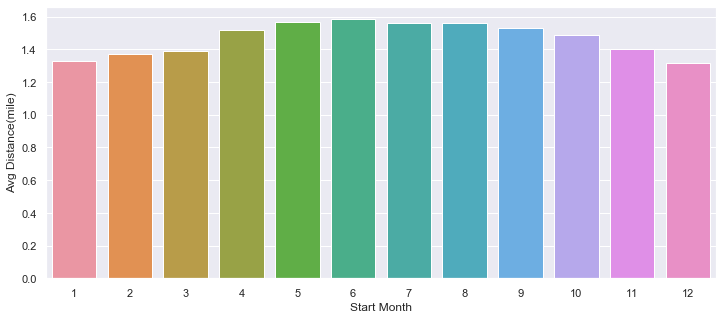

In [15]:
monthly_distance = train_df.groupby('start_month').mean()[['distance']].reset_index()
monthly_distance.columns=['Start Month','Avg Distance(mile)']
plt.figure(figsize=(12,5))
sns.set_style('darkgrid')
sns.barplot('Start Month','Avg Distance(mile)',data=monthly_distance);

## Weather Impact

### Temperature's impact on ride counts

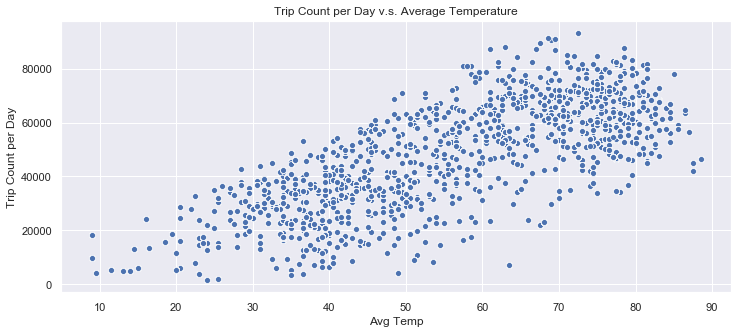

In [16]:
TEMP = train_df[['TAVG','trip_duration','trip_per_day','daily_avg_distance']]
TEMP.columns = ['Avg Temp','Avg Trip Duration(s)','Trip Count per Day','Avg Distance(mile)']
plt.figure(figsize=(12,5))
sns.scatterplot(x='Avg Temp',y='Trip Count per Day',data = TEMP).set(title = 'Trip Count per Day v.s. Average Temperature');

### Unusual Weather Conditions' impact on Ride Counts

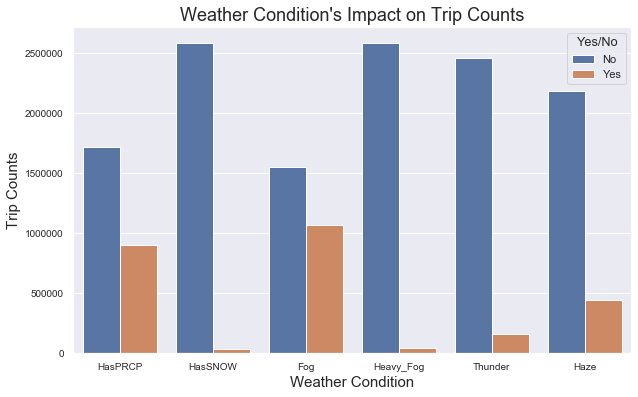

In [17]:
extreme_weather = train_df[['HasPRCP','HasSNOW','Fog', 'Heavy_Fog', 'Thunder', 'Haze']].apply(pd.value_counts)
extreme_weather= extreme_weather.unstack().reset_index()
extreme_weather.columns=['Weather Condition','Yes/No','Trip Counts']
extreme_weather['Yes/No']=['Yes' if x==1 else 'No' for x in extreme_weather['Yes/No']]
plt.figure(figsize=(10,6))
plt.rcParams["axes.labelsize"] = 15
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.title("Weather Condition's Impact on Trip Counts", fontdict = {'fontsize' : 18})
sns.barplot(x='Weather Condition', y ='Trip Counts', hue ='Yes/No', data = extreme_weather);

## Number of Stations in Different Quarters

In [18]:
station_change = train_df[['start_date','start_station_name','start_station_longitude','start_station_latitude','start_year']]
station_change['start_date'] = pd.to_datetime(station_change['start_date'])
station_change['quarter'] = station_change['start_date'].dt.quarter
station_change['quarter'] = list(map(lambda a, b: "%dQ%d" %(a, b), station_change['start_year'],station_change['quarter']))

In [19]:
station_each_qt= [station_change[station_change.quarter == x].start_station_name.unique() for x in station_change.quarter.unique()]

In [20]:
station_cts = list(map(lambda x:len(x),station_each_qt))
quarters = list(station_change.quarter.unique())
quarter_cts = pd.DataFrame({'Quarter':quarters,'Station_counts':station_cts})

In [21]:
quarter_cts

,Quarter,Station_counts
0,2017Q1,621
1,2017Q2,625
2,2017Q3,683
3,2017Q4,761
4,2018Q1,766
5,2018Q2,777
6,2018Q3,779
7,2018Q4,779
8,2019Q1,779
9,2019Q2,804


Text(0.5, 1.0, 'Station Counts from 2017 to 2019')

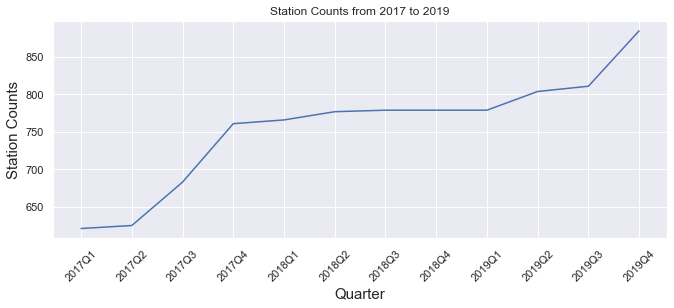

In [22]:
sns.lineplot(x = 'Quarter',y ='Station_counts',data = quarter_cts);
plt.xticks(rotation = 45)
plt.ylabel('Station Counts')
plt.title('Station Counts from 2017 to 2019')

In [23]:
station_added = list(map(lambda x,y : (set(y)-set(x)),station_each_qt[0:],station_each_qt[1:]))
station_removed = list(map(lambda x,y : (set(x)-set(y)),station_each_qt[0:],station_each_qt[1:]))

In [24]:
station_added_dict = dict(zip(station_change.quarter.unique()[1:],station_added))
station_added_dict_2 = {v: k for k,vv in station_added_dict.items() for v in vv}
station_added_df = pd.DataFrame({'Quarter': list(station_added_dict_2.values()),
                                 'Stations':list(station_added_dict_2.keys())})
station_added_df['Add/Removed'] = 'Added'

In [25]:
station_removed_dict = dict(zip(station_change.quarter.unique()[1:],station_removed))
station_removed_dict_2 = {v: k for k,vv in station_removed_dict.items() for v in vv}
station_removed_df = pd.DataFrame({'Quarter': list(station_removed_dict_2.values()),
                                 'Stations':list(station_removed_dict_2.keys())})
station_removed_df['Add/Removed'] = 'Removed'

In [26]:
station_added_removed = pd.concat([station_added_df,station_removed_df])

In [27]:
station_location = train_df.groupby('start_station_name').agg({'start_station_longitude':'first','start_station_latitude':'first'}).reset_index()

In [28]:
station_added_removed.merge(station_location,how='left',left_on='Stations',right_on='start_station_name').\
drop('start_station_name',axis=1).dropna().to_csv('Stations_add_remove.csv')

## Weekdays and Weekends

Text(0.5, 0, 'Is Weekday')

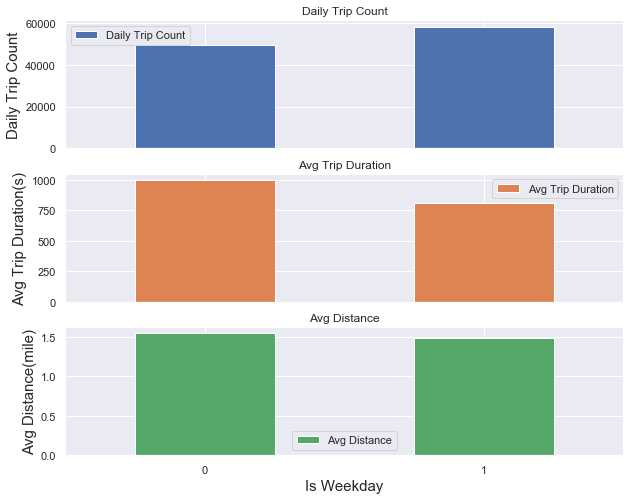

In [29]:
Weekday = train_df[['Isweekday','trip_per_day','daily_avg_trip_duration','daily_avg_distance']]
Weekday.columns =  ['Isweekday','Daily Trip Count','Avg Trip Duration','Avg Distance']
Weekday = Weekday.groupby('Isweekday').agg('mean').reset_index()
cols_plot = ['Daily Trip Count','Avg Trip Duration','Avg Distance']
axes = Weekday[cols_plot].plot(kind='bar', linestyle='None', figsize=(10, 8), subplots=True,rot = 0);
axes[0].set_ylabel('Daily Trip Count')
axes[1].set_ylabel('Avg Trip Duration(s)')
axes[2].set_ylabel('Avg Distance(mile)')
axes[2].set_xlabel('Is Weekday')

### Hourly Trend for all stations

In [30]:
hourly = train_df.groupby(['start_station_name','start_hour']).agg({'start_station_checkout_counts':'mean'}).reset_index()

In [31]:
Hourly = hourly.merge(station_location,how='left',on='start_station_name')
Hourly.columns = ['Station Name','Start Hour','Checkout Counts','Longitude','Latitude']
Hourly.to_csv('Hourly.csv')

## Rush Hours

In [32]:
# Group by the start_hour and see the frequency correspond to each starting hour
train_df.groupby('start_hour').count()[['trip_duration']].sort_values(by = 'trip_duration', ascending = False).head(6)

,trip_duration
start_hour,
17,265638
18,252642
8,217408
16,193310
19,176039
9,172826


In [33]:
# Assuming bikers during peak hours on weekdays are commuting
rushhours = [8,9,16,17,18,19]
train_df['Commute'] = np.where(((train_df['Isweekday']==1) &
                                        (train_df['start_hour'].isin(rushhours))),1,0)

In [34]:
test_df['Commute'] = np.where(((test_df['Isweekday']==1) &
                                        (test_df['start_hour'].isin(rushhours))),1,0)

## Top 50 Stations on Weekdays and Weekend

In [35]:
top50_weekdays = train_df.loc[train_df['Isweekday']==1].groupby(['start_station_name']).\
agg({'start_station_total_counts':'mean','start_station_latitude':'first', 'start_station_longitude':'first'}).\
sort_values(by = 'start_station_total_counts', ascending = False).head(50)

top50_weekends = train_df.loc[train_df['Isweekday']==0].groupby(['start_station_name']).\
agg({'start_station_total_counts':'mean','start_station_latitude':'first', 'start_station_longitude':'first'}).\
sort_values(by = 'start_station_total_counts', ascending = False).head(50)

In [36]:
# Merge Dataset and export csv for Tableau Visualization
top50_weekdays['Isweekday'] ='Weekday'
top50_weekends['Isweekday'] ='Weekend'
top50_all_days = pd.concat([top50_weekdays,top50_weekends],axis = 0).reset_index()
top50_all_days.columns=['Station Name','Trip Count','Latitude','Longitude','Isweekday']
top50_all_days.to_csv('Top50_All_Days.csv')

In [37]:
top50_all_days.head()

,Station Name,Trip Count,Latitude,Longitude,Isweekday
0,Pershing Square North,121.562306,40.751873,-73.977706,Weekday
1,E 47 St & Park Ave,77.238786,40.755103,-73.974987,Weekday
2,Broadway & E 22 St,75.276594,40.740343,-73.989551,Weekday
3,8 Ave & W 31 St,68.389542,40.750585,-73.994685,Weekday
4,West St & Chambers St,66.641673,40.717548,-74.013221,Weekday


In [38]:
plt.figure(figsize=(15,10))
plt.plot(top50_weekdays['start_station_longitude'].values, top50_weekdays['start_station_latitude'].values, 'ro',alpha = 0.5,markersize=8)
plt.plot(top50_weekends['start_station_longitude'].values, top50_weekends['start_station_latitude'].values, 'bv',alpha = 0.5,markersize=8)
mplleaflet.display(tiles='cartodb_positron')

- Weekends hotspots are shown as blue triangles. They are centered around central park, Hudson, West Village. 
- Weekdays hotspots are shown as red circiles. They are mostly in central Manhattan. 

## Top 50 start stations on weekdays during rush hours

In [39]:
top50_weekdays_rush_start = train_df.loc[train_df['Commute']==1].groupby(['start_station_name']).\
agg({'start_station_checkout_counts':'mean','start_station_latitude':'first', 'start_station_longitude':'first'}).\
sort_values(by = 'start_station_checkout_counts', ascending = False).head(50)
top50_weekdays_rush_start['Isstart'] ='Start Station'
top50_weekdays_rush_start = top50_weekdays_rush_start.reset_index()
top50_weekdays_rush_start.columns=['Station Name','Trip Count','Latitude','Longitude','Isstart']

In [40]:
# Top 50 end stations on weekdays during rush hours
top50_weekdays_rush_end = train_df.loc[train_df['Commute']==1].groupby(['end_station_name']).\
agg({'end_station_checkin_counts':'mean','end_station_latitude':'first', 'end_station_longitude':'first'}).\
sort_values(by = 'end_station_checkin_counts', ascending = False).head(50)
top50_weekdays_rush_end['Isstart'] = 'End Station'
top50_weekdays_rush_end.reset_index(inplace=True)
top50_weekdays_rush_end.columns=['Station Name','Trip Count','Latitude','Longitude','Isstart']

In [41]:
# Merge Dataset and export csv for Tableau Visualization
top50_rushhours = pd.concat([top50_weekdays_rush_start,top50_weekdays_rush_end],axis = 0)
top50_rushhours.to_csv('Top50_Rushhours.csv')

In [42]:
top50_rushhours.head()

,Station Name,Trip Count,Latitude,Longitude,Isstart
0,Pershing Square North,83.028197,40.751873,-73.977706,Start Station
1,E 47 St & Park Ave,67.152897,40.755103,-73.974987,Start Station
2,Broadway & E 22 St,64.051162,40.740343,-73.989551,Start Station
3,Penn Station Valet - Valet Scan,59.275862,40.751284,-73.996925,Start Station
4,W 52 St & 6 Ave,56.863782,40.761330,-73.979820,Start Station


## K-mean Clustering 
- Create clusters on dock stations based on location and usage, what else could be useful? 

In [43]:
train_df = train_df.loc[train_df.distance<200]
station = train_df.groupby(['start_station_name']).agg({'start_station_total_counts':'mean','Percent_usage':'mean',
                                                         'distance': 'mean'})

station.reset_index(inplace=True)

In [44]:
station = station.dropna(how = 'any')
station= station.loc[station.Percent_usage<5]
station.shape

(957, 4)

In [45]:
station.sample(10)

,start_station_name,start_station_total_counts,Percent_usage,distance
487,E 98 St & Park Ave,3.886667,0.155467,1.491759
823,Stanhope St & Fairview Ave,1.000000,0.058824,0.794610
855,University Pl & E 8 St,22.816904,0.735418,1.091663
469,E 84 St & 1 Ave,11.175376,0.371709,1.652959
15,10 St & 7 Ave,5.553932,0.241475,1.214932
894,W 16 St & The High Line,26.724197,0.952168,1.544986
170,Baltic St & 5 Ave,7.291776,0.270078,1.348640
71,30 Ave & 21 St,2.778816,0.185254,1.296755
959,W 87 St & Amsterdam Ave,10.020990,0.233046,1.812910
278,Centre St & Chambers St,38.857216,0.996339,1.660857


In [46]:
scaler = StandardScaler()
scaler.fit(station.iloc[:,1:])
station_scaled = scaler.transform(station.iloc[:,1:])
kmeans = KMeans()

In [47]:
station_scaled

array([[-0.54954961, -0.42998128, -0.02786023],
       [ 1.49178566,  0.97356282, -0.82738289],
       [ 0.89559824,  0.71684109, -0.76815411],
       ...,
       [ 2.1275828 ,  1.72643706,  2.3151431 ],
       [ 0.41590101,  0.90660214,  0.01120285],
       [ 1.03002644,  0.85581861, -0.72224467]])

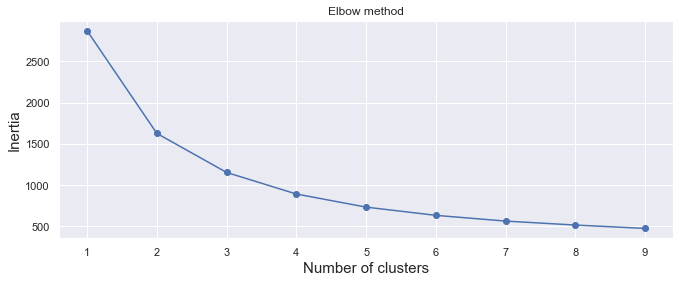

In [48]:
plot_inertia(kmeans, station_scaled, range(1, 10))

In [49]:
kmeans.set_params(n_clusters=4)
kmeans.fit(station_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=4, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [50]:
kmeans.cluster_centers_

array([[-0.5423628 , -0.50638379, -0.34787207],
       [ 0.82345519,  0.80084841, -0.35538931],
       [ 2.57664674,  2.49939716,  0.15463647],
       [-0.55124491, -0.60247679,  1.64295973]])

In [51]:
#pd.concat([station,station_labels],axis=1)
station['cluster']= kmeans.labels_

In [52]:
station_geo = train_df.groupby('start_station_name')[['start_station_longitude','start_station_latitude']].apply(lambda x:x.iloc[0])
station_geo.reset_index(inplace=True)

In [53]:
cluster = station.merge(station_geo,how='left',on='start_station_name')

In [54]:
# cluster.to_csv('cluster.csv')

In [55]:
cluster = pd.read_csv('cluster.csv',index_col=0)

In [56]:
cluster.groupby('cluster').agg({'start_station_total_counts':'mean','Percent_usage':'mean','distance':'mean'})

,start_station_total_counts,Percent_usage,distance
cluster,,,
0,6.345607,0.200063,2.228039
1,22.568313,0.625371,1.424351
2,6.387274,0.228053,1.430480
3,43.131303,1.138812,1.620540


- **Cluster 3** are stations that have the highest activity among all other clusters. 
    - These stations are close by transit hubs (e.g. Grand Central, Penn Station, Port Authority) and major points of interest (e.g. Central Park)
    - Number of stations: 61
- **Cluster 1** are stations that have the second highest activity.
    - They are mostly located in central Manhattan.
    - Number of stations: 242
- **Cluster 2** are stations that have the lowest activity.
    - They are mostly located in upper East Side, Long Island city, Brooklyn.
    - Number of stations: 505
- **Cluster 0** are stations that have similar activity as cluster 0 (total checkin and checkout counts) but travel the furthest in distance.
    - They are mostly located in Upper West Side, Manhattan Valley, and Bushwick in Brooklyn. 
    - Number of stations: 149

In [57]:
cluster_reduced = cluster[['start_station_name','cluster']]
train_df = train_df.merge(cluster_reduced, how='left',on='start_station_name')
test_df = test_df.merge(cluster_reduced, how='left',on='start_station_name')

### Closer Look at Cluster 0: Low Activity and Long Distance

In [58]:
cluster0= train_df.loc[train_df['cluster']==0]
cluster0.distance.describe()

count    155827.000000
mean          2.150739
std           2.189532
min           0.095948
25%           0.848480
50%           1.705029
75%           2.898748
max         160.281218
Name: distance, dtype: float64

In [59]:
cluster0_dest = cluster0.groupby('end_station_name').agg({'trip_duration':'count',
                                        'end_station_longitude':'first',
                                       'end_station_latitude':'first',
                                       'distance':'mean'})
cluster0_dest = cluster0_dest.loc[cluster0_dest.trip_duration>200].drop(['trip_duration','distance'],axis=1).reset_index()
cluster0_dest.columns=['Station_name','Longitude','Latitude']
cluster0_dest['Isstart']='End Station'

In [60]:
cluster0_start=cluster0[['start_station_name','start_station_longitude','start_station_latitude']]
cluster0_start.columns=['Station_name','Longitude','Latitude']
cluster0_start['Isstart']='Start Station'
cluster0_start.drop_duplicates(inplace=True)

In [61]:
# pd.concat([cluster0_start,cluster0_dest]).to_csv('cluster0.csv')

### Closer Look at Cluster 2 : Lowest Activity and Short Distance

In [62]:
cluster2= train_df.loc[train_df['cluster']==2]
cluster2.distance.describe()

count    635092.000000
mean          1.444306
std           1.529391
min           0.034852
25%           0.609070
50%           1.045316
75%           1.858960
max         176.761049
Name: distance, dtype: float64

In [63]:
cluster2_dest = cluster2.groupby('end_station_name').agg({'trip_duration':'count',
                                        'end_station_longitude':'first',
                                       'end_station_latitude':'first',
                                       'distance':'mean'})
cluster2_dest = cluster2_dest.loc[cluster2_dest.trip_duration>500].drop(['trip_duration','distance'],axis=1).reset_index()
cluster2_dest.columns=['Station_name','Longitude','Latitude']
cluster2_dest['Isstart']='End Station'

In [64]:
cluster2_start=cluster2[['start_station_name','start_station_longitude','start_station_latitude']]
cluster2_start.columns=['Station_name','Longitude','Latitude']
cluster2_start['Isstart']='Start Station'
cluster2_start.drop_duplicates(inplace=True)

In [65]:
# pd.concat([cluster2_start,cluster2_dest]).to_csv('cluster2.csv')

### Net Hourly Change in Bikes For All Stations

In [66]:
# Net Change in bike: negative means more checkout than checkin, vice versa. 
cols = ['start_station_name','start_hour','start_station_checkin_counts','start_station_checkout_counts',\
        'start_station_longitude','start_station_latitude','tot_docks','cluster','Commute']
train_net = train_df[cols].copy()
# Only look at rush hours 
train_net = train_net.loc[train_net.Commute==1]
train_net['net_change'] = train_net['start_station_checkin_counts'] - train_net['start_station_checkout_counts']
# Normalize based on the capacity of each station 
train_net['net_change_percent'] =train_net['net_change']/train_net['tot_docks']

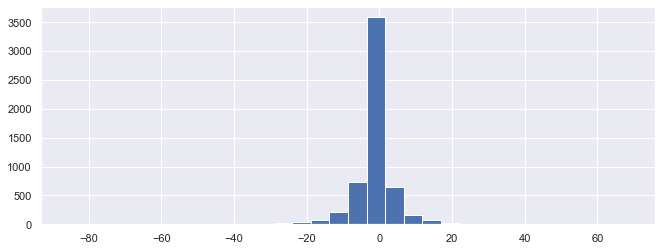

In [67]:
station_hourly_net = train_net.groupby(['start_station_name','start_hour']).\
agg({'net_change':'mean','net_change_percent':'mean',\
     'start_station_longitude':'first','start_station_latitude':'first'}).reset_index()

station_hourly_net.net_change.hist(bins=30);

In [68]:
low_threshold_percent = np.mean(station_hourly_net.net_change_percent) - 2*np.std(station_hourly_net.net_change_percent)
high_threshold_percent = np.mean(station_hourly_net.net_change_percent) + 2*np.std(station_hourly_net.net_change_percent)

In [69]:
neg_stations=station_hourly_net.loc[station_hourly_net.net_change_percent < low_threshold_percent].start_station_name.unique()

In [70]:
pos_stations = station_hourly_net.loc[station_hourly_net.net_change_percent > high_threshold_percent].start_station_name.unique()

In [71]:
High_neg = pd.DataFrame({'Station':neg_stations})
High_pos = pd.DataFrame({'Station':pos_stations})
Abnormal_stations = pd.concat([High_neg,High_pos])

In [72]:
station_activity = Abnormal_stations.merge(station_hourly_net,how='left',left_on='Station',right_on='start_station_name').drop('start_station_name',axis=1)
station_activity['Normality'] = ['Highly Negative' if x < low_threshold_percent else
                                 'Highly Positive' if x > high_threshold_percent else 'Normal' for x in station_activity['net_change_percent']]
station_activity.to_csv('station_activity.csv')

## Top 200 Dock Stations at All Times 

In [73]:
Top200_ID = list(train_df.groupby(['start_station_ID']).agg({'trip_duration':'count'}).\
sort_values(by='trip_duration',ascending=False).head(200).index)

In [74]:
Top200 = train_df.loc[train_df['start_station_ID'].isin(Top200_ID)]

In [75]:
Top200_test = test_df.loc[test_df['start_station_ID'].isin(Top200_ID)]

In [76]:
selected_cols=['start_station_latitude','start_station_longitude', 'start_hour',\
              'start_year','start_month','start_day','start_dayofweek','start_station_checkout_counts',\
              'start_station_checkin_counts','AWND', 'PRCP', 'SNOW', 'SNWD', 'TMAX','TMIN', 'Fog',\
               'Heavy_Fog', 'Thunder', 'Hail', 'Glaze', 'Haze','TAVG','HasPRCP', 'HasSNOW',\
               'tot_docks', 'Percent_usage','Isweekday','holidays', 'Commute','cluster'] 
Top200 = Top200[selected_cols]
Top200_test = Top200_test[selected_cols]

In [77]:
Top200.drop_duplicates(inplace=True)
Top200_test.drop_duplicates(inplace=True)

In [78]:
Top200.to_csv('Top200_Stations.csv')
Top200_test.to_csv('Top200_test_Stations.csv')